### MVP Report Notebook
This notebook will walk you through some of the EDA, the FSM, and the ICD-10 code model.  All other work can be found in the Notebooks folder, which contains exploratory and modeling notebooks.  Information on creating the database used for this project can be found in the Data folder.  Source code for functions, queries, and building tables can be found in the src folder.
#### Introduction 

Hospitals depend on having accurate medical coding that reflects all events in a patient encounter from the time of admission to discharge.  Coding inaccuracies can cause claim denials and result in lost revenue for a hospital.  This is primarily a concern for a hospital's revenue cycle executive.  

#### Goal 
This project aims to use Natural Language Processing to correctly predict an ICD-10 code using physician notes from a patient's medical record. 

#### Data Set
Data used in this project was obtained from https://mimic.physionet.org

MIMIC-IV, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available from: http://www.nature.com/articles/sdata201635

Additional information on the specific data used for this project is outlined [here](https://github.com/aspotter99/NLP-and-dx-codes/tree/master/Data/README.md)

#### Definitions
- Medical Record: A complete recording of an individual patient's key clinical data and medical history.  This includes demographics, vital signs, diagnoses, procesured, medications, treatment plans, notes, diagnostic tests, immunizations, etc.
- Medical Coding:  Transformation of clinical data from sources such as physician notes into universal alphanumeric codes.  The currently used code set is ICD-10. 
- ICD:  nternational Classification of Diseases and is the global health information standard for mortality and morbidity statistics.
- DRG: A diagnosis-related group (DRG) is a patient classification system that standardizes prospective payment to hospitals and encourages cost containment initiatives. In general, a DRG payment covers all charges associated with an inpatient stay from the time of admission to discharge. (hmsa.com)

#### Methodology
- This project will utilize Natural Language Processing and a Naive Bayes Multinomial classification algorithm.  
- The dataset was labeled with both a diagnosis and a diagnosis code which were used in the initial models.  
- Text of physician notes from a patient was processed and used to train and predict the correct diagnosis/diagnosis code.

Because we are concerned with accurately predicting both of the diagnosis codes, the model will use accuracy to evaluate performance.

In [1]:
#Import SQLite3 and Pandas for use in EDA

import sqlite3 as sl
import pandas as pd

In [2]:
#Connect to the database
conn = sl.connect('../../Data/patient_data.db')
c = conn.cursor()

In [3]:
#Confirm that tables necessary are present

res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print (name[0])

ADMISSIONS
CALLOUT
CPTEVENTS
DX_ICD
D_CPT
DRGCODES
ICUSTAY
NOTES
PATIENTS
SERVICES
DRG


### We are going to take a quick look at the admissions table.  This table contains data related to each individual admission to the hospital - each admission is a separate record and can be identified using HADM_ID.  The DIAGNOSIS column in this table contains the premiminary diagnosis for a patient on admission to the hospital.  The below query will return the top 10 diagnosis by number of admissions.

In [4]:
#Query the admissions table  

diag = pd.read_sql('''select diagnosis, count(*) from admissions group by diagnosis order by count(*) desc limit 10;''',conn)
diag

,DIAGNOSIS,count(*)
0,NEWBORN,7823
1,PNEUMONIA,1566
2,SEPSIS,1184
3,CONGESTIVE HEART FAILURE,928
4,CORONARY ARTERY DISEASE,840
5,CHEST PAIN,778
6,INTRACRANIAL HEMORRHAGE,713
7,ALTERED MENTAL STATUS,712
8,GASTROINTESTINAL BLEED,686
9,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,583


### From the above query, there are a number of diagnoses that would be suitable for a first simple model.  I will be using Gastrointestinal Bleed and Intracranial Hemorrhage since we have a fairly even distribution (686 and 713) in the data. 

In [5]:
#query to select records with GI Bleeds or IC Hemorrhages.
data = pd.read_sql('''select * 
                      from admissions 
                      where diagnosis in ('GASTROINTESTINAL BLEED','INTRACRANIAL HEMORRHAGE') 
                      order by subject_id;''',conn)
data

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,46,144073,2133-02-20 18:21:00,2133-02-24 14:42:00,None,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Medicare,None,CATHOLIC,SINGLE,WHITE,None,None,GASTROINTESTINAL BLEED,0,1
1,112,174105,2194-06-13 18:39:00,2194-06-18 16:50:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,None,JEWISH,MARRIED,WHITE,2194-06-13 15:19:00,2194-06-13 20:05:00,GASTROINTESTINAL BLEED,0,1
2,158,169433,2170-02-03 11:38:00,2170-02-06 16:49:00,None,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,None,JEWISH,MARRIED,WHITE,2170-02-03 09:10:00,2170-02-03 12:00:00,GASTROINTESTINAL BLEED,0,1
3,186,164405,2176-09-25 23:13:00,2176-10-01 19:20:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,GREE,GREEK ORTHODOX,MARRIED,WHITE,2176-09-25 22:23:00,2176-09-25 23:27:00,GASTROINTESTINAL BLEED,0,1
4,212,189635,2189-11-07 21:35:00,2189-11-10 17:00:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,CATHOLIC,MARRIED,WHITE,2189-11-07 17:07:00,2189-11-07 22:34:00,INTRACRANIAL HEMORRHAGE,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1394,98948,125469,2136-10-21 14:26:00,2136-10-29 20:10:00,None,EMERGENCY,CLINIC REFERRAL/PREMATURE,REHAB/DISTINCT PART HOSP,Medicaid,ENGL,UNOBTAINABLE,SINGLE,UNABLE TO OBTAIN,2136-10-21 11:48:00,2136-10-21 14:43:00,INTRACRANIAL HEMORRHAGE,0,1
1395,99183,184631,2157-03-01 18:49:00,2157-03-04 16:22:00,None,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,2157-03-01 16:54:00,2157-03-01 21:07:00,GASTROINTESTINAL BLEED,0,1
1396,99184,171203,2193-12-16 21:53:00,2193-12-19 16:55:00,2193-12-19 16:55:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,ENGL,PROTESTANT QUAKER,WIDOWED,WHITE,2193-12-16 20:07:00,2193-12-16 22:45:00,INTRACRANIAL HEMORRHAGE,1,1
1397,99366,136021,2197-03-20 23:57:00,2197-05-18 13:38:00,None,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Medicaid,ARAB,UNOBTAINABLE,None,UNABLE TO OBTAIN,2197-03-20 21:38:00,2197-03-20 23:30:00,INTRACRANIAL HEMORRHAGE,0,1


#### We are going to be using the notes from a patient's medical record to try to predict the diagnosis.  The Notes table houses all notes that were entered on a patient chart.  The combination of CATEGORY and DESCRIPTION columns will define the type of note that is recorded in the TEXT field.

In [6]:
#The text column is the free text of the note thay was entered into the chart.

notes = pd.read_sql('''select * from notes limit 10;''',conn)
notes

,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,22532,167853.0,2151-08-04,None,None,Discharge summary,Report,None,None,Admission Date: [**2151-7-16**] Dischar...
1,13702,107527.0,2118-06-14,None,None,Discharge summary,Report,None,None,Admission Date: [**2118-6-2**] Discharg...
2,13702,167118.0,2119-05-25,None,None,Discharge summary,Report,None,None,Admission Date: [**2119-5-4**] D...
3,13702,196489.0,2124-08-18,None,None,Discharge summary,Report,None,None,Admission Date: [**2124-7-21**] ...
4,26880,135453.0,2162-03-25,None,None,Discharge summary,Report,None,None,Admission Date: [**2162-3-3**] D...
5,53181,170490.0,2172-03-08,None,None,Discharge summary,Report,None,None,Admission Date: [**2172-3-5**] D...
6,20646,134727.0,2112-12-10,None,None,Discharge summary,Report,None,None,Admission Date: [**2112-12-8**] ...
7,42130,114236.0,2150-03-01,None,None,Discharge summary,Report,None,None,Admission Date: [**2150-2-25**] ...
8,56174,163469.0,2118-08-12,None,None,Discharge summary,Report,None,None,Admission Date: [**2118-8-10**] ...
9,56174,189681.0,2118-12-09,None,None,Discharge summary,Report,None,None,Admission Date: [**2118-12-7**] ...


#### We need to see what types of notes are in a record, so let's just look at one individual hospital admission and see what we have.

In [7]:
# All note records associated with a single hospital admission for one patient 

text = pd.read_sql('''select * from notes where subject_id = 112 AND hadm_id = '174105';''',conn)
text

,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,112,174105.0,2194-06-18,None,None,Discharge summary,Report,NaN,None,Admission Date: [**2194-6-13**] Dischar...
1,112,174105.0,2194-06-16,None,None,ECG,Report,NaN,None,Leads V1 and V2 reversed\nSinus rhythm\nOtherw...
2,112,174105.0,2194-06-16,None,None,ECG,Report,NaN,None,Sinus bradycardia\nLeft ventricular hypertroph...
3,112,174105.0,2194-06-14,None,None,ECG,Report,NaN,None,Sinus rhythm.\nInferior ST-T changes are nonsp...
4,112,174105.0,2194-06-13,None,None,ECG,Report,NaN,None,Sinus rhythm\nAnterolateral ST-T changes sugge...
5,112,174105.0,2194-06-13,None,None,ECG,Report,NaN,None,Sinus rhythm\nInferior/lateral ST-T changes ar...
6,112,174105.0,2194-06-14,2194-06-14 04:55:00,2194-06-14 05:15:00,Nursing/other,Report,18565.0,None,NURSING MICU NOTE 7P-7A\n\nPT [**Name (NI) 577...


#### There are quite a few different note types, for the first pass, we will look at the Nursing/other and Discharge Summary.  

In [8]:
#there are quite a few different note types, for this first pass we will only look at Nursing/other and Discharge summary.
#most of the columns will not be needed for the model, but I am keeping them for now to see if they might add any value later
#this query takes quite some time to run, so I don't want to do it multiple times.

data = pd.read_sql("""
                   SELECT adm.subject_id, 
                          adm.hadm_id,
                          admission_type,
                          admission_location,
                          notes.chartdate,
                          notes.charttime,
                          notes.category,
                          notes.description,
                          notes.iserror,
                          notes.text,
                          adm.diagnosis
                    FROM admissions as adm
                    JOIN notes on adm.subject_id = notes.subject_id
                         AND adm.hadm_id = notes.hadm_id
                    WHERE adm.diagnosis in ('GASTROINTESTINAL BLEED','INTRACRANIAL HEMORRHAGE') 
                         AND category in ('Nursing/other','Discharge summary')
                    ORDER BY adm.subject_id, adm.hadm_id, chartdate""",conn)
data.to_csv('../../Data/first_model_data.csv')
data

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMISSION_LOCATION,CHARTDATE,CHARTTIME,CATEGORY,DESCRIPTION,ISERROR,TEXT,DIAGNOSIS
0,46,144073,EMERGENCY,CLINIC REFERRAL/PREMATURE,2133-02-21,2133-02-21 05:07:00,Nursing/other,Report,None,MICU NPN 7P-7A\nPt. came from IR around 2200 p...,GASTROINTESTINAL BLEED
1,46,144073,EMERGENCY,CLINIC REFERRAL/PREMATURE,2133-02-24,None,Discharge summary,Report,None,Admission Date: [**2133-2-20**] Dischar...,GASTROINTESTINAL BLEED
2,112,174105,EMERGENCY,EMERGENCY ROOM ADMIT,2194-06-14,2194-06-14 04:55:00,Nursing/other,Report,None,NURSING MICU NOTE 7P-7A\n\nPT [**Name (NI) 577...,GASTROINTESTINAL BLEED
3,112,174105,EMERGENCY,EMERGENCY ROOM ADMIT,2194-06-18,None,Discharge summary,Report,None,Admission Date: [**2194-6-13**] Dischar...,GASTROINTESTINAL BLEED
4,158,169433,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,2170-02-03,2170-02-03 13:29:00,Nursing/other,Report,None,NURSING ADMISSION NOTE 1200-1500\nPT IS A 67 Y...,GASTROINTESTINAL BLEED
...,...,...,...,...,...,...,...,...,...,...,...
11682,98948,125469,EMERGENCY,CLINIC REFERRAL/PREMATURE,2136-10-29,None,Discharge summary,Report,None,Admission Date: [**2136-10-21**] ...,INTRACRANIAL HEMORRHAGE
11683,99183,184631,EMERGENCY,CLINIC REFERRAL/PREMATURE,2157-03-04,None,Discharge summary,Report,None,Admission Date: [**2157-3-1**] D...,GASTROINTESTINAL BLEED
11684,99184,171203,EMERGENCY,EMERGENCY ROOM ADMIT,2193-12-19,None,Discharge summary,Report,None,Admission Date: [**2193-12-16**] ...,INTRACRANIAL HEMORRHAGE
11685,99366,136021,EMERGENCY,CLINIC REFERRAL/PREMATURE,2197-05-18,None,Discharge summary,Report,None,Admission Date: [**2197-3-20**] ...,INTRACRANIAL HEMORRHAGE


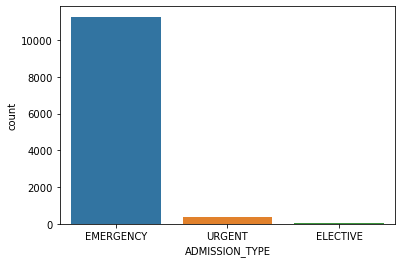

In [9]:
#Let's explore this set a little to see what we are working with.

import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.countplot(x=data.ADMISSION_TYPE)

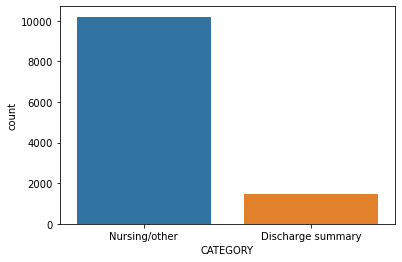

In [10]:
#As expected, most of these admissions are Emergency, this makes sense as we have a population of ICU patients

ax = sns.countplot(x=data.CATEGORY)

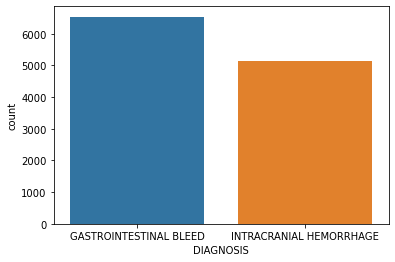

In [11]:
#LOTS of Nursing/other notes, this also makes sense as nursing staff will interact with a patient multiple times during a stay
#the discharge summary is only written once upon discharge of a patient 

ax = sns.countplot(x = data.DIAGNOSIS)

In [12]:
#as we expected there is a pretty even distribution of our two initial diagnoses.  Let's go ahead and put this into an FSM
#some additional imports will be needed

# Standard imports
import numpy as np
import matplotlib.pyplot as plt

# Model selection
from sklearn.model_selection import train_test_split

# Preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string
import unicodedata
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, WhitespaceTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob
import re

# Models
from sklearn.naive_bayes import MultinomialNB

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix


#.py file
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

np.random.seed(42)
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [13]:
sw = stopwords.words('english')

def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def doc_preparer(doc, stop_words=sw):
    '''  
    :param doc: a document from the corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in stop_words]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

#Preprocess text data and train/test split - at this point we will not be extending the stopwords used so that we have a baseline to compare

X = data.TEXT.astype('str')
y = data.DIAGNOSIS.astype('str')

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.25)

token_docs = [doc_preparer(doc, sw) for doc in X_train]
token_docs[0]

'neuro pt remain pleasant good historian pr c arithitic pain receive tylenol mg desire effect reach within min pt remain afebrile time neuro deficit note cv pt begin hr shift drop sbp hr occ pac pt fill ileostomy time loose maroon stool pt give bolus cc n quickly respond return baseline regard v pt drop hct pt receive two unit prbc take red tag study intervention take place hct rechecked follow scan result two hr later pt drop sbp pt c burn sensation upper abd denies c p sob h r occ pac pt respond cc n bolus return baseline v hct send reconfirm result hct pt since receive three additional unit micu intern resident pt bedside observe pt output total cc frothy maroon brown liquid maroon red ace inhibitor presently hold g team notify resp pt remain clear lung sound field c sob resp rate remain regular continue monitor closely pt receive multiple bolus blood transfusion gu gi pt remain npo time abd remain soft non tender bowel sound easily audible ileostomy bag change without difficulty pt

In [14]:
# Validation train-test split to build our first model
# For this first model, we will use a count vectorizer and will limit the df to 250 with 500 features

X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train, test_size=.25, random_state=42)

cv = CountVectorizer(max_df=250,max_features=500)

X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)
X_t_vec

,abgs,abnormal,abnormality,abuse,acid,acidosis,add,addition,address,administer,...,withdrawal,withdraws,woman,word,wound,wrist,xii,yet,yr,zosyn
9493,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10392,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9928,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10755,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9865,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11329,0,0,1,0,0,0,0,1,0,0,...,1,0,1,0,0,0,1,0,0,1
1538,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9806,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5079,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
#run the model!

mnb = MultinomialNB()
mnb.fit(X_t_vec, y_t)
prior_0 = y_t.value_counts()['GASTROINTESTINAL BLEED']/len(y_t)
prior_1 = y_t.value_counts()['INTRACRANIAL HEMORRHAGE']/len(y_t)

print(prior_0, prior_1)
print(np.log(prior_1))

0.5586490187129165 0.4413509812870835
-0.8179148441421723


In [16]:
# run the metrics!

y_hat = mnb.predict(X_t_vec)
print(accuracy_score(y_t, y_hat))
print(confusion_matrix(y_t,y_hat))

0.7664688878746386
[[3384  288]
 [1247 1654]]


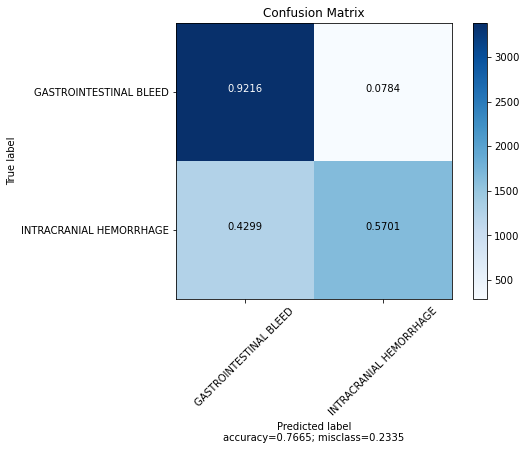

<Figure size 432x288 with 0 Axes>

In [17]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
plot_confusion_matrix(cm = np.array(confusion_matrix(y_t,y_hat)), 
                      normalize    = True,
                      target_names = ['GASTROINTESTINAL BLEED','INTRACRANIAL HEMORRHAGE'],
                      title        = "Confusion Matrix")
plt.savefig('../../Reports/images/ConfMat_FSM_train.png')

#### Before we move on to test data, let's take a look at the validation set.

In [18]:
X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)
X_val_vec

prior_0 = y_test.value_counts()['GASTROINTESTINAL BLEED']/len(y_test)
prior_1 = y_test.value_counts()['INTRACRANIAL HEMORRHAGE']/len(y_test)

y_hat = mnb.predict(X_val_vec)
print(accuracy_score(y_val, y_hat))
print(confusion_matrix(y_val,y_hat))


0.7709854014598541
[[1130  109]
 [ 393  560]]


#### The first model is hitting .77 for accuracy (we are using accuracy here because false negatives and false positives are both equally bad, so we want our model to prioritize accuracy.  Let's see if it does as well on the test data.

In [19]:
#and let's run this on our test data
X_test_vec = cv.transform(X_test)
X_test_vec  = pd.DataFrame.sparse.from_spmatrix(X_test_vec)
X_test_vec.columns = sorted(cv.vocabulary_)
X_test_vec.set_index(y_test.index, inplace=True)
X_test_vec

,abgs,abnormal,abnormality,abuse,acid,acidosis,add,addition,address,administer,...,withdrawal,withdraws,woman,word,wound,wrist,xii,yet,yr,zosyn
7868,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4526,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3068,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
468,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11275,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4339,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3753,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7201,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
prior_0 = y_test.value_counts()['GASTROINTESTINAL BLEED']/len(y_test)
prior_1 = y_test.value_counts()['INTRACRANIAL HEMORRHAGE']/len(y_test)

print(prior_0, prior_1)
print(np.log(prior_1))

0.5574948665297741 0.44250513347022585
-0.8153032135387873


In [21]:
y_hat = mnb.predict(X_test_vec)
print(accuracy_score(y_test, y_hat))
print(confusion_matrix(y_test,y_hat))

0.7676249144421629
[[1508  121]
 [ 558  735]]


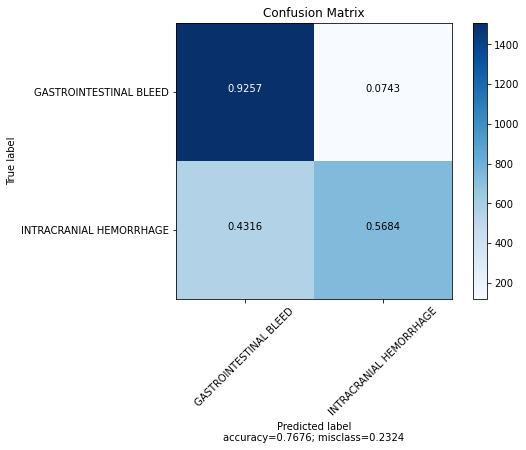

<Figure size 432x288 with 0 Axes>

In [22]:
plot_confusion_matrix(cm = np.array(confusion_matrix(y_test,y_hat)), 
                      normalize    = True,
                      target_names = ['GASTROINTESTINAL BLEED','INTRACRANIAL HEMORRHAGE'],
                      title        = "Confusion Matrix")

plt.savefig('../../Reports/images/ConfMat_FSM_test.png')

#### Accuracy of .77 on the test data, not bad!

#### so, not too bad for a first model, the accuracy isn't great (.77) but it is very good at predicting Gastrointestinal Bleeds.  Unfortunately, it is not very good at intracranial hemorrhages.  Let's see if we can improve this by using only one type of note - we will use Discharge Summary since there is only one of those per patient.  It is likely that we are seeing some issues with classification here because we have so many different notes for each patient.

In [23]:
# filtering data so we only have the discharge summary type notes.

no_ds = data[(data.CATEGORY == 'Discharge summary')]
no_ds

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMISSION_LOCATION,CHARTDATE,CHARTTIME,CATEGORY,DESCRIPTION,ISERROR,TEXT,DIAGNOSIS
1,46,144073,EMERGENCY,CLINIC REFERRAL/PREMATURE,2133-02-24,None,Discharge summary,Report,None,Admission Date: [**2133-2-20**] Dischar...,GASTROINTESTINAL BLEED
3,112,174105,EMERGENCY,EMERGENCY ROOM ADMIT,2194-06-18,None,Discharge summary,Report,None,Admission Date: [**2194-6-13**] Dischar...,GASTROINTESTINAL BLEED
7,158,169433,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,2170-02-06,None,Discharge summary,Report,None,Admission Date: [**2170-2-3**] Discharg...,GASTROINTESTINAL BLEED
21,186,164405,EMERGENCY,EMERGENCY ROOM ADMIT,2176-10-01,None,Discharge summary,Report,None,Admission Date: [**2176-9-25**] ...,GASTROINTESTINAL BLEED
26,212,189635,EMERGENCY,EMERGENCY ROOM ADMIT,2189-11-10,None,Discharge summary,Report,None,Admission Date: [**2189-11-7**] ...,INTRACRANIAL HEMORRHAGE
...,...,...,...,...,...,...,...,...,...,...,...
11682,98948,125469,EMERGENCY,CLINIC REFERRAL/PREMATURE,2136-10-29,None,Discharge summary,Report,None,Admission Date: [**2136-10-21**] ...,INTRACRANIAL HEMORRHAGE
11683,99183,184631,EMERGENCY,CLINIC REFERRAL/PREMATURE,2157-03-04,None,Discharge summary,Report,None,Admission Date: [**2157-3-1**] D...,GASTROINTESTINAL BLEED
11684,99184,171203,EMERGENCY,EMERGENCY ROOM ADMIT,2193-12-19,None,Discharge summary,Report,None,Admission Date: [**2193-12-16**] ...,INTRACRANIAL HEMORRHAGE
11685,99366,136021,EMERGENCY,CLINIC REFERRAL/PREMATURE,2197-05-18,None,Discharge summary,Report,None,Admission Date: [**2197-3-20**] ...,INTRACRANIAL HEMORRHAGE


In [24]:
# running the same model with only discharge summary

X = no_ds.TEXT.astype('str')
y = no_ds.DIAGNOSIS.astype('str')

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.25)

token_docs = [doc_preparer(doc, sw) for doc in X_train]
token_docs[0]

'admission date discharge date date birth sex f service neurosurgery allergies codeine attend first name lf chief complaint headache nausea vomit major surgical invasive procedure none history present illness f patient w alzheimer dementia p fall c h difficulty w vision n v today past medical history alzheimer dementia p fall month w leave humerus fx social history non contributory family history non contributory physical exam upon admission mental status awake asleep arousable cooperative exam orientation orient person partially place language speech fluent good comprehension dysarthria paraphasic error ii pupil equally round reactive light mm bilaterally visual field difficult examine likely partial right homonymous hemianopsia iii iv vi extraocular movement intact bilaterally without nystagmus v vii facial strength sensation intact symmetric xii tongue midline without fasciculation motor normal bulk tone bilaterally strength full power throughout pronator drift sensation intact ligh

In [25]:
# using the count vectorizer for this model

X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train, test_size=.25, random_state=42)

cv = CountVectorizer(max_df=250,max_features=500)

X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)
X_t_vec

,abnormal,abnormality,abuse,acid,active,additional,afebrile,afib,age,airway,...,wean,weight,wheeze,white,wife,woman,worsen,wound,xii,yo
2544,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,1,1,0,0
11214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,1,0
1215,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,6,0,0,0,0,0
8786,0,0,0,0,0,0,0,0,0,2,...,0,0,0,1,0,2,0,0,0,0
11389,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11680,2,0,0,0,9,0,1,0,2,0,...,1,1,1,1,0,0,0,2,0,1
9990,7,4,0,0,0,0,0,0,2,1,...,0,1,0,3,2,0,2,0,0,1
11614,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
9787,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,1,0


In [26]:
mnb = MultinomialNB()
mnb.fit(X_t_vec, y_t)
prior_0 = y_t.value_counts()['GASTROINTESTINAL BLEED']/len(y_t)
prior_1 = y_t.value_counts()['INTRACRANIAL HEMORRHAGE']/len(y_t)

print(prior_0, prior_1)
print(np.log(prior_1))

0.5311750599520384 0.46882494004796166
-0.7575258423733809


In [27]:
y_hat = mnb.predict(X_t_vec)
print(accuracy_score(y_t, y_hat))
print(confusion_matrix(y_t,y_hat))

0.9832134292565947
[[440   3]
 [ 11 380]]


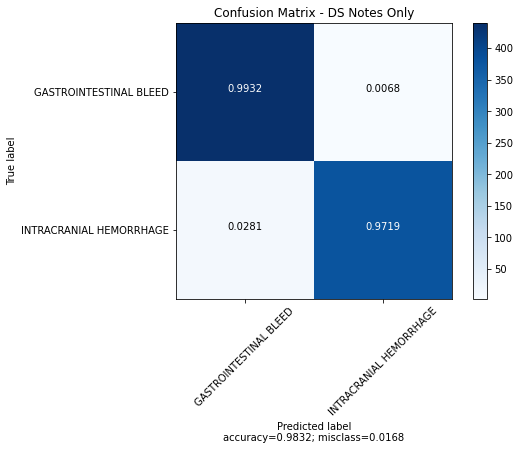

<Figure size 432x288 with 0 Axes>

In [28]:
plot_confusion_matrix(cm = np.array(confusion_matrix(y_t,y_hat)), 
                      normalize    = True,
                      target_names = ['GASTROINTESTINAL BLEED','INTRACRANIAL HEMORRHAGE'],
                      title        = "Confusion Matrix - DS Notes Only")
plt.savefig('../../Reports/Images/ConfMat_DS.png')

#### Let's take a quick look at the validation set before we move on to the test set. 

In [29]:
X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)
X_val_vec

prior_0 = y_test.value_counts()['GASTROINTESTINAL BLEED']/len(y_test)
prior_1 = y_test.value_counts()['INTRACRANIAL HEMORRHAGE']/len(y_test)

y_hat = mnb.predict(X_val_vec)
print(accuracy_score(y_val, y_hat))
print(confusion_matrix(y_val,y_hat))

0.974910394265233
[[140   5]
 [  2 132]]


#### This is quite an improvement over the first model using both nursing/other and discharge summary notes from a patient record.  Accuracy is up to .97, which is phenominal, and the model is pretty good at predicting both diagnoses.  Let's take a look at the test data and see if this is still performing as well. 

In [30]:
X_test_vec = cv.transform(X_test)
X_test_vec  = pd.DataFrame.sparse.from_spmatrix(X_test_vec)
X_test_vec.columns = sorted(cv.vocabulary_)
X_test_vec.set_index(y_test.index, inplace=True)
X_test_vec

,abnormal,abnormality,abuse,acid,active,additional,afebrile,afib,age,airway,...,wean,weight,wheeze,white,wife,woman,worsen,wound,xii,yo
1911,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5559,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11236,0,0,5,1,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6876,0,0,0,1,2,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
11620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11435,0,0,0,0,0,4,0,0,0,0,...,0,1,0,1,0,2,0,0,1,0
5246,0,0,0,2,0,0,0,0,6,0,...,0,1,0,0,0,0,0,1,0,1
6373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [31]:
prior_0 = y_test.value_counts()['GASTROINTESTINAL BLEED']/len(y_test)
prior_1 = y_test.value_counts()['INTRACRANIAL HEMORRHAGE']/len(y_test)

print(prior_0, prior_1)
print(np.log(prior_1))

0.48787061994609165 0.5121293800539084
-0.6691779904469489


In [32]:
y_hat = mnb.predict(X_test_vec)
print(accuracy_score(y_test, y_hat))
print(confusion_matrix(y_test,y_hat))

0.9811320754716981
[[180   1]
 [  6 184]]


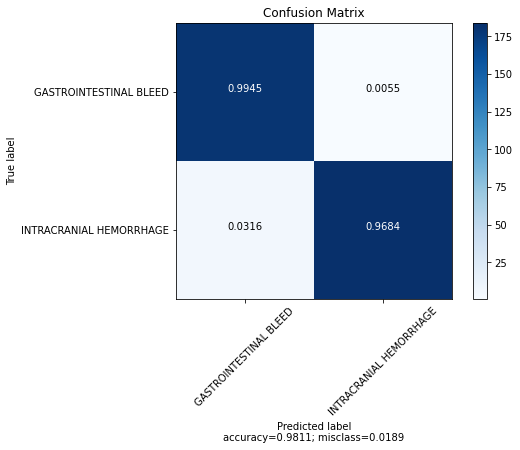

<Figure size 432x288 with 0 Axes>

In [33]:
plot_confusion_matrix(cm = np.array(confusion_matrix(y_test,y_hat)), 
                      normalize    = True,
                      target_names = ['GASTROINTESTINAL BLEED','INTRACRANIAL HEMORRHAGE'],
                      title        = "Confusion Matrix")

plt.savefig('../../Reports/Images/ConfMat_DS_test.png')

#### So, really good!  However, a quick look at the notes reveals that the diagnosis is in the discharge summary, so while this is a good result, it is unlikely that this is going to be super helpful with an ICD-10 code. 

#### Going to add in MS DRG codes, length of stay, patient age (in this dataset, patients over 89 will show as 300+ due to the way records were de-identified), ICD-9 and ICD-10 code.  used https://www.aapc.com/icd-10/codes/ converter to get the correct icd10 code.
This next model will use only the ICD-10 codes, but I want to have the DRG and other columns available for the next iteration.

In [34]:
# as with the query earlier, many of these columns are not needed for this model, but this takes quite some time to run 
#so I am including the columns here in order to not have to run this again

new_data = pd.read_sql('''
                    SELECT adm.subject_id, 
                          adm.hadm_id,
                          notes.category,
                          notes.description,
                          notes.text,
                          adm.diagnosis,
                          cast(JulianDay(adm.dischtime) - JulianDay(adm.admittime) as int) as LOS,
                          cast((JulianDay(adm.admittime) - JulianDay(pt.DOB)) / 365  as int) as Age_at_Admission,
                          cast((JulianDay(pt.DOD) - JulianDay(pt.DOB)) / 365 as int) as Age_at_Death,
                          drg.DRG_CODE,
                          drg.DRG_TYPE,
                          drg.DESCRIPTION AS DRG_DESC,
                          drg.DRG_SEVERITY,
                          drg.DRG_MORTALITY,
                          dx.icd9_code,
                          CASE WHEN dx.icd9_code = 53100 THEN 'K25.0'
                               WHEN dx.icd9_code = 5789 THEN 'K92.2'
                               WHEN dx.icd9_code = 4019 THEN 'I16.9'
                               WHEN dx.icd9_code = 42731 THEN 'I48.91'
                               WHEN dx.icd9_code = 431 THEN 'I61.9'
                               else 'other' end as 'icd10_code',
                         pt.gender,
                         pt.dob,
                         pt.dod,
                         pt.dod_hosp,
                         pt.expire_flag
                    FROM admissions as adm
                    JOIN notes on adm.subject_id = notes.subject_id
                         AND adm.hadm_id = notes.hadm_id
                    JOIN drg on drg.subject_id = adm.subject_id and drg.hadm_id = adm.hadm_id
                    JOIN DX_ICD dx on dx.subject_id = adm.subject_id and dx.hadm_id = adm.hadm_id
                    JOIN patients pt on pt.subject_id = adm.subject_id 
                    WHERE dx.icd9_code in ('53100','5789','4019','42731','431')
                    AND drg.drg_type = 'MS'
                    AND notes.category in ('Discharge summary','Physician');
                       ''',conn)
new_data

,SUBJECT_ID,HADM_ID,CATEGORY,DESCRIPTION,TEXT,DIAGNOSIS,LOS,Age_at_Admission,Age_at_Death,DRG_CODE,...,DRG_DESC,DRG_SEVERITY,DRG_MORTALITY,ICD9_CODE,icd10_code,GENDER,DOB,DOD,DOD_HOSP,EXPIRE_FLAG
0,5689,157267,Discharge summary,Report,Admission Date: [**2124-9-18**] ...,EKG CHANGES,10,76,76.0,391,...,"ESOPHAGITIS, GASTROENT & MISC DIGEST DISORDERS...",None,None,4019,I16.9,F,2048-07-14 00:00:00,2125-01-08 00:00:00,2125-01-08 00:00:00,1
1,5689,157267,Discharge summary,Report,Admission Date: [**2124-9-18**] ...,EKG CHANGES,10,76,76.0,391,...,"ESOPHAGITIS, GASTROENT & MISC DIGEST DISORDERS...",None,None,42731,I48.91,F,2048-07-14 00:00:00,2125-01-08 00:00:00,2125-01-08 00:00:00,1
2,28389,139931,Discharge summary,Report,Admission Date: [**2152-9-15**] ...,ABDOMINAL PAIN;AORTIC DISSECTION;TELEMETRY,10,47,NaN,329,...,MAJOR SMALL & LARGE BOWEL PROCEDURES W MCC,None,None,4019,I16.9,F,2104-11-22 00:00:00,None,None,0
3,16072,198295,Discharge summary,Report,Admission Date: [**2184-11-19**] ...,ATRIAL FIBRILLATION;RESPIRATORY FAILURE,5,41,41.0,870,...,SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS,None,None,4019,I16.9,F,2143-11-23 00:00:00,2184-11-24 00:00:00,2184-11-24 00:00:00,1
4,16072,198295,Discharge summary,Report,Admission Date: [**2184-11-19**] ...,ATRIAL FIBRILLATION;RESPIRATORY FAILURE,5,41,41.0,870,...,SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS,None,None,42731,I48.91,F,2143-11-23 00:00:00,2184-11-24 00:00:00,2184-11-24 00:00:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20856,60929,109316,Discharge summary,Report,Admission Date: [**2142-6-29**] ...,SEIZURE,5,58,NaN,896,...,ALCOHOL/DRUG ABUSE OR DEPENDENCE W/O REHABILIT...,None,None,4019,I16.9,F,2084-06-29 00:00:00,None,None,0
20857,75779,123505,Discharge summary,Report,Admission Date: [**2128-8-6**] D...,CONGESTIVE HEART FAILURE,21,73,NaN,216,...,CARDIAC VALVE & OTH MAJ CARDIOTHORACIC PROC W ...,None,None,4019,I16.9,M,2055-06-23 00:00:00,None,None,0
20858,75779,123505,Discharge summary,Report,Admission Date: [**2128-8-6**] D...,CONGESTIVE HEART FAILURE,21,73,NaN,216,...,CARDIAC VALVE & OTH MAJ CARDIOTHORACIC PROC W ...,None,None,42731,I48.91,M,2055-06-23 00:00:00,None,None,0
20859,46449,110075,Discharge summary,Addendum,"Name: [**Known lastname 13679**],[**Known fir...",CHEST PAIN,11,74,NaN,234,...,CORONARY BYPASS W CARDIAC CATH W/O MCC,None,None,42731,I48.91,M,2100-02-13 00:00:00,None,None,0


In [35]:
#let's see what the distribution of the icd-10 codes looks like with this new dataframe

new_data.icd10_code.value_counts()

I16.9     11728
I48.91     7587
I61.9       802
K92.2       722
K25.0        22
Name: icd10_code, dtype: int64

In [36]:
# it looks like I61.9 and K92.2 are fairly evenly distributed in this data, so we will use those for this model iteration

md = new_data.loc[(new_data['icd10_code']== 'I61.9') | (new_data['icd10_code']=='K92.2')]
md

,SUBJECT_ID,HADM_ID,CATEGORY,DESCRIPTION,TEXT,DIAGNOSIS,LOS,Age_at_Admission,Age_at_Death,DRG_CODE,...,DRG_DESC,DRG_SEVERITY,DRG_MORTALITY,ICD9_CODE,icd10_code,GENDER,DOB,DOD,DOD_HOSP,EXPIRE_FLAG
27,18376,150349,Discharge summary,Report,Admission Date: [**2148-11-1**] ...,RIGHT LUNG CANCER;WEAKNESS,12,75,75.0,54,...,NERVOUS SYSTEM NEOPLASMS W MCC,None,None,431,I61.9,M,2072-12-29 00:00:00,2148-11-14 00:00:00,2148-11-14 00:00:00,1
59,32212,135900,Discharge summary,Report,Admission Date: [**2158-10-27**] ...,UPPER GASTROINTESTINAL BLEED,4,300,300.0,377,...,G.I. HEMORRHAGE W MCC,None,None,5789,K92.2,F,1858-10-27 00:00:00,2158-11-10 00:00:00,2158-11-10 00:00:00,1
69,30746,155603,Discharge summary,Report,Admission Date: [**2131-8-22**] ...,ALTERED MENTAL STATUS,5,76,NaN,377,...,G.I. HEMORRHAGE W MCC,None,None,5789,K92.2,M,2055-03-16 00:00:00,None,None,0
102,24900,153828,Discharge summary,Report,Admission Date: [**2172-10-28**] ...,LOWER GI BLEED;TELEMETRY,3,50,50.0,356,...,OTHER DIGESTIVE SYSTEM O.R. PROCEDURES W MCC,None,None,5789,K92.2,M,2122-06-10 00:00:00,2172-11-01 00:00:00,2172-11-01 00:00:00,1
112,27261,194743,Discharge summary,Addendum,"Name: [**Known lastname **],[**Known firstnam...",STROKE;TELEMETRY;TRANSIENT ISCHEMIC ATTACK,5,78,NaN,61,...,ACUTE ISCHEMIC STROKE W USE OF THROMBOLYTIC AG...,None,None,431,I61.9,F,2092-04-18 00:00:00,None,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20762,61991,146377,Discharge summary,Report,Admission Date: [**2159-7-31**] ...,INTRACRANIAL HEMORRHAGE,11,51,NaN,64,...,INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION...,None,None,431,I61.9,F,2108-06-12 00:00:00,None,None,0
20777,73241,149216,Discharge summary,Report,Admission Date: [**2118-8-14**] ...,HEPATIC ENCEPHALOPATHY,23,64,64.0,441,...,"DISORDERS OF LIVER EXCEPT MALIG,CIRR,ALC HEPA ...",None,None,5789,K92.2,M,2054-03-21 00:00:00,2118-09-07 00:00:00,2118-09-07 00:00:00,1
20802,40292,186944,Discharge summary,Report,Admission Date: [**2116-8-28**] ...,LOWER GI BLEED,3,82,NaN,920,...,COMPLICATIONS OF TREATMENT W CC,None,None,5789,K92.2,M,2033-12-03 00:00:00,None,None,0
20808,52298,181420,Discharge summary,Report,Admission Date: [**2171-4-16**] ...,HYPERKALEMIA,30,61,62.0,659,...,KIDNEY & URETER PROCEDURES FOR NON-NEOPLASM W MCC,None,None,431,I61.9,M,2109-06-02 00:00:00,2171-11-26 00:00:00,2171-11-26 00:00:00,1


In [37]:
#train/test split this new model, process text

X = md.TEXT.astype('str')
y = md.icd10_code.astype('str')

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.25)

token_docs = [doc_preparer(doc, sw) for doc in X_train]
token_docs[0]

'admission date discharge date date birth sex f service medicine allergy topiramate aripiprazole shellfish bee pollen attend first name lf chief complaint am major surgical invasive procedure paracentesis thoracentesis history present illness f history alcoholic hepatitis recent admission date range gi bleed without clear source subsequently develop c diff treat iv flagyl po vanc taper sbp hcap treat vanc cefepime discharge nursing home yesterday transfer back hospital am report ems hospital rehab febrile today pcxr c w pna go svt rate transfer hospital give adenosine verapamil total l n give apap vanc zosyn transfer ed afebrile alter unable answer question labs show wbc stable hct plt electrolytes wnl exception low mg low ca trop inr ct p obtain look toxic megacolon negative however show large new right pleural effusion lead atelectasis near collapse right low lobe also multifocal ill define opacity lul may reflect infectious process also splenomegaly varix signialying portal hyperten

In [38]:
# validation split
# this model, like the earlier model will use a count vectorizer and will limit df to 250 and features to 500

X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train, test_size=.25, random_state=42)

cv = CountVectorizer(max_df=250,max_features=500)

X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)
X_t_vec

,abnormal,abuse,acid,active,addition,additional,address,afebrile,afib,albumin,...,warfarin,wave,wean,weight,white,wife,woman,wound,yeast,zosyn
8066,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18374,0,0,0,0,0,1,2,0,0,1,...,0,1,0,0,0,1,0,0,0,0
2548,0,0,1,2,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
5399,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2418,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6334,0,0,0,0,0,0,0,0,2,0,...,0,0,0,3,0,1,0,0,0,0
413,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,2
1272,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
18944,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0


In [39]:
# Still working with a multinomial naive bayes model

mnb.fit(X_t_vec, y_t)
prior_0 = y_t.value_counts()['I61.9']/len(y_t)
prior_1 = y_t.value_counts()['K92.2']/len(y_t)

print(prior_0, prior_1)
print(np.log(prior_1))

0.5390898483080513 0.46091015169194866
-0.774552153696658


In [40]:
y_hat = mnb.predict(X_t_vec)
print(accuracy_score(y_t, y_hat))
print(confusion_matrix(y_t,y_hat))

0.9568261376896149
[[432  30]
 [  7 388]]


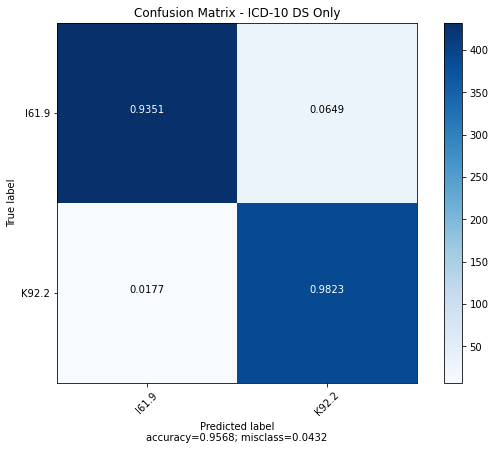

<Figure size 432x288 with 0 Axes>

In [41]:
plot_confusion_matrix(cm = np.array(confusion_matrix(y_t,y_hat)), 
                      normalize    = True,
                      target_names = ['I61.9','K92.2'],
                      title        = "Confusion Matrix - ICD-10 DS Only")
plt.savefig('../../Reports/Images/ConfMat_DS_ICD-10_train')

#### As before, running this on the validation set before moving on to the test set

In [42]:
X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)
X_val_vec

prior_0 = y_test.value_counts()['I61.9']/len(y_test)
prior_1 = y_test.value_counts()['K92.2']/len(y_test)

y_hat = mnb.predict(X_val_vec)
print(accuracy_score(y_val, y_hat))
print(confusion_matrix(y_val,y_hat))

0.9475524475524476
[[132  10]
 [  5 139]]


#### Pretty good on the test data, accuracy of .95.  Let's see if that is just as good on the test set. 

In [43]:
X_test_vec = cv.transform(X_test)
X_test_vec  = pd.DataFrame.sparse.from_spmatrix(X_test_vec)
X_test_vec.columns = sorted(cv.vocabulary_)
X_test_vec.set_index(y_test.index, inplace=True)
X_test_vec

,abnormal,abuse,acid,active,addition,additional,address,afebrile,afib,albumin,...,warfarin,wave,wean,weight,white,wife,woman,wound,yeast,zosyn
10269,0,0,0,1,0,1,0,1,0,0,...,0,2,0,1,0,0,0,2,0,0
1126,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,1,0,0
13446,0,0,0,0,0,0,1,0,0,2,...,0,0,0,0,0,0,0,0,0,1
18973,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,2,0,1,0,0
11146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2747,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15398,4,0,1,2,0,1,3,2,0,1,...,0,0,0,0,0,1,0,0,0,1
20395,0,1,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16014,0,4,2,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [44]:
prior_0 = y_test.value_counts()['I61.9']/len(y_test)
prior_1 = y_test.value_counts()['K92.2']/len(y_test)

print(prior_0, prior_1)
print(np.log(prior_1))

0.5196850393700787 0.48031496062992124
-0.7333132222852801


In [45]:
y_hat = mnb.predict(X_test_vec)
print(accuracy_score(y_test, y_hat))
print(confusion_matrix(y_test,y_hat))

0.9448818897637795
[[181  17]
 [  4 179]]


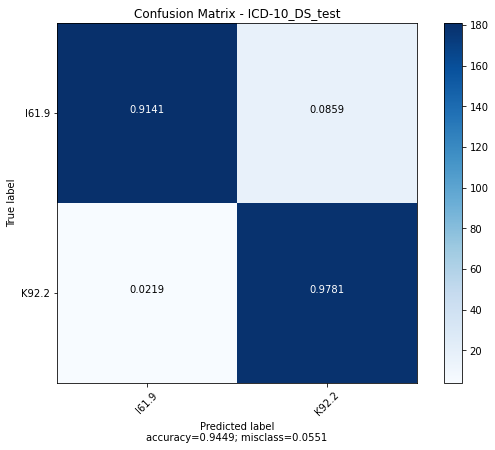

<Figure size 432x288 with 0 Axes>

In [46]:
plot_confusion_matrix(cm = np.array(confusion_matrix(y_test,y_hat)), 
                      normalize    = True,
                      target_names = ['I61.9','K92.2'],
                      title        = "Confusion Matrix - ICD-10_DS_test")

plt.savefig('../../Reports/Images/ConfMat_DS_IDC-10_test.png')

#### Accuracy of .94!  

#### this is a really good result.  Our model is hitting .95 train/.94 test on accuracy with a binomial model.  The model is slightly better at correctly predicting K92.2, but this is a very good result.  
#### We can conclude that it is possible to use NLP to correctly identify the correct ICD-10 code from physician notes. However, more investigation will need to be done to determine what this model is picking up on before we can determine if this would be generalizable to other datasets.  Because all the data used in this model was for ICU admissions, it would be interesting to see if this can pick up these codes for other admissions as well.  Another note, this dataset was for admissions that were prior to ICD-10 being implemented, so the ICD-10 codes were obtained using a cross-walk rather than the data being labelled by experienced medical coders, and that could also be causing some issues as the ICD-10 codes are much more specific than the ICD-9 codes that were in use when this data was gathered.    Due to time constraints, these will remain an avenue for further exploration. 

#### Some additional next steps would be to bring in additional codes to train and test the model - rarely is medical coding a binary decision.  
#### In addition, this type of processing of physician notes could be used to determine if a DRG should have a CC/MCC - these indicate that a patient had additional underlying conditions that require a higher level of care.  Missing CC/MCC DRG can cost hospitals a great deal of money due to lower reimbursements than were appropriate for the level of care that was received. 